# Case Study 7

__Team Members:__ Amber Clark, Andrew Leppla, Jorge Olmos, Paritosh Rai

# Content
* [Objective](#objective)
* [Data Evaluation](#data-evaluation)
    - [Loading Data](#loading-data) 
    - [Data Summary](#data-summary)
    - [Missing Values](#missing-values)
    - [Exploratory Data Analysis (EDA)](#eda)
* [Model Preparations](#model-preparations)
    - [Sampling & Scaling Data](#sampling-scaling-data)
    - [Evaluation Metrics](#proposed-metrics)
* [Model Building & Evaluations](#model-building)
    - [Results](#performance-analysis)
* [Conclusion](#conclusion)
    - [Final Model Proposal](#final_model)
    - [Examining Feature Importance](#examining-feature-importance)
    - [Future Considerations, Model Enhancements and Alternative Modeling Approaches](#model-enhancements)

## Objective: <a id='objective'>

The objective of this case study is to classify a binary target in an anonymous dataset with the goal of reducing monetary losses as much as possible for the customer.

# Data Evaluation <a id='data-evaluation'>
    

## Loading Data <a id='loading-data'>

In [90]:
# standard libraries
import os
import pandas as pd
import numpy as np
#import re
import os
from IPython.display import Image
from abc import ABC, abstractmethod
import time
#import sklearn
#import time

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from tabulate import tabulate
from IPython.display import clear_output
import xgboost

# data pre-processing
from scipy.io import arff
#from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.impute._base import _BaseImputer
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection._split import BaseShuffleSplit
from sklearn.datasets import load_digits
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

# prediction models
import tensorflow as tf
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.svm._base import BaseSVC 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.metrics import AUC
# import warnings filter
import warnings
warnings.filterwarnings('ignore')
from warnings import simplefilter 
simplefilter(action='ignore', category=FutureWarning)

In [2]:
class FilePathManager:
    def __init__(self, local_dir: str):
        self.local_dir = local_dir
    
    def retrieve_full_path(self):
        return os.getcwd()+'/'+self.local_dir

In [3]:
class Loader:
    df = pd.DataFrame()
    
    def load_data(self, file_name):
        pass
    
    def get_df(self):
        pass
    
    def size(self):
        return len(self.df)

In [4]:
from typing import Callable
 
class CSVLoader(Loader):
    def __init__(self, file_path_manager: FilePathManager):
        self.file_path_manager = file_path_manager
        
    def load_data(self, _prepare_data: Callable[[pd.DataFrame], pd.DataFrame] = None):
        self.df = pd.read_csv(self.file_path_manager.retrieve_full_path())
        if _prepare_data:
            self.df = _prepare_data(self.df)
    
    def get_df(self):
        return self.df;
    
    def size(self):
        return len(self.df)  

In [5]:
def clean_data(df):
    df['y'] = df['y'].astype(int)
    df['x32'] = df['x32'].str.replace('%','').astype(float)
    df['x37'] = df['x37'].str.replace('$','').astype(float)
    return df

In [6]:
loader = CSVLoader(FilePathManager('final_project(5).csv'))
loader.load_data(clean_data)

## Data Summary <a id='data-summary'>
    
The dataset consists of fifty (50) features and a binary target class. There is no metadata or other descriptive information for the dataset, and the fifty feature labels are numbered from "x0" to "x49". There are 160,000 observations in the dataset; less than 0.03% of the features were missing data, and the imputation of these missing values is described below in the Missing Data section. Most of the features provided are numeric, but five were initially imported as text features.
    
Three of the five text features were identified as continents, months of the year, and days of the week. The values were cleaned up for spelling correction and consistency. The other two text object columns were numeric columns with a special character introduced in the data; column x32 had a trailing "%" and column x37 had a leading "$". These characters were removed so that these columns would be treated as numeric.
    



## Missing Values <a id='missing-values'>



All of the variables, except the target class, had missing values. The chart below depicts the number of observations missing values for each feature. Note: Even though the plot doesn't show missing values for categorical features, they do have missing values which are represented as nan's and so are missing from the plot.

<img src='https://raw.githubusercontent.com/olmosjorge28/QTW-SPRING-2022/main/ds7333_case_study_7/visuals/missing_values.png'></img>

The number of missing values was consistently around 20-40 missing observations for each column (less than 0.03% of 160,000 observations). For the logistic regression and neural network models, the mean of each column was used to impute the missing values for the numeric data, and the mode of each column was used for the missing categorical features.  

For the XGBoost model, the algorithm can automatically handle missing values and find their optimal split for modeling, so no imputation was done prior to modeling. 

## Exploratory Data Analysis (EDA) <a id='eda'>



The numeric data was examined to view the scales of the variables, and the data needs normalization to be effectively used in most types of models without issues. 

For two model types, logistic regression and neural network, the categorical data for the three text columns were one-hot encoded to produce binary features for each of the values within those variables. In this data, there were three continents, twelve months, and five days of the week, so the one-hot encoding process did not contribute to creating an excess of sparsity in the dataframe that would be used for modeling. After one-hot encoding, the total number of explanatory features has increased to 67.
For the third model type, XGBoost, the categorical data were not one-hot encoded but rather label-encoded so the tree-based algorithm could split the data effectively.


### Balance of Target

The target classes are considered balanced in the dataset, with roughly 40:60 split between the positive and negative classes, as depicted below.

<img src='https://raw.githubusercontent.com/olmosjorge28/QTW-SPRING-2022/main/ds7333_case_study_7/visuals/y_dist.png'></img>

### Categorical Variables
The three categorical variables were x24 (continent), x29 (month), and x30 (weekday).  Asia was disproportionately represented for continent, and months and weekday were both approximately normally distributed when ordered by time.  

Looking at the target class, the categorical  variables did not change.  These are likely not strong predictors for the target variable.  

<img src='https://raw.githubusercontent.com/olmosjorge28/QTW-SPRING-2022/main/ds7333_case_study_7/visuals/cat_feature_dist.png'></img>

<img src='https://raw.githubusercontent.com/olmosjorge28/QTW-SPRING-2022/main/ds7333_case_study_7/visuals/cat_feature_dist_by_y.png'></img>

### Continuous Variables - Scaling
Variable x37 (with \\$ values) had a very wide scale compared to other variables (-\\$5000 to \\$6000).  The remaining variables still had varied scales based on the plot below.  All continuous features were scaled using StandardScaler to ensure features were appropriately weighted for Logistic Regression feature importance.  Scaling the data was less important for XGBoost (tree-based ensemble) and Neural Network models.

<img src='https://raw.githubusercontent.com/olmosjorge28/QTW-SPRING-2022/main/ds7333_case_study_7/visuals/box_plot_ex_x37.png'></img>

# Model Preparations <a id='model-preparations'/>

In [8]:
class BaseImputer:
    def fit(self, X, y=None):
        pass
    
    def transform(self, X):
        pass

class BaseModel:

    def fit(self, X, y, sample_weight=None):
        pass
    
    def predict(self, X):
        pass

## Sampling and Scaling Data <a id='sampling-scaling-data'/>

In [9]:
class Modeling:
    _X_train_fitted = None
    _X_test_fitted = None
    _y_train = None
    _y_test = None
    _y_preds = None
    _y_preds_proba = None
    
    def __init__(self, data: pd.DataFrame, 
                 target_name: str, 
                 shuffle_splitter: BaseShuffleSplit, 
                 imputer: BaseImputer, 
                 model: BaseModel, scaler = None, encoder = None):
        self._data = data
        self._target_name = target_name
        self._shuffle_splitter = shuffle_splitter
        self._imputer = imputer
        self._model = model
        self._encoder = encoder
        self._X, self._y = self._split_data()
        self._scaler = scaler
        
    @property
    def X(self):
        return self._X
    
    @property
    def y(self):
        return self._y

    @property
    def model(self):
        return self._model
    
    @model.setter
    def model(self, model):
        self._model = model
     
    @property
    def X_train(self):
        return self._X_train_fitted
    
    @property
    def X_test(self):
        return self._X_test_fitted
    
    @property
    def y_train(self):
        return self._y_train
    
    @property
    def y_test(self):
        return self._y_test
    
    @property
    def y_preds(self):
        return self._y_preds
    
    def _split_data(self):
        X = self._data.copy()
        return X.drop([self._target_name], axis=1) , X[self._target_name]
    
    def _shuffle_split(self):
        X = self.X
        y = self.y
        for train_index, test_index in self._shuffle_splitter.split(X,y):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y[train_index], y[test_index]
        return X_train, X_test, y_train, y_test
    
    def _fit_imputer(self, train):
        if self._imputer is not None:
            self._imputer.fit(train)
    
    def _fit_scaler(self, train, cont_vars = None):
        transform_cols = None
        if cont_vars is None:
            transform_cols = self.X.columns
        else:
            transform_cols = cont_vars
            
        if self._scaler is not None:
            self._scaler.fit(train[transform_cols])
    
    def _impute_data(self, X: pd.DataFrame):
        if self._imputer is not None:
            return pd.DataFrame(self._imputer.transform(X), columns = self.X.columns, index = X.index)
        return X
    
    def _scale_data(self, X: pd.DataFrame, cont_vars = None):
        transform_cols = None
        if cont_vars is None:
            transform_cols = X.columns
        else:
            transform_cols = cont_vars
        scaled_data = X[transform_cols]
        if self._scaler is not None:
            scaled_data = pd.DataFrame(self._scaler.transform(X[transform_cols]), columns = transform_cols)
        X[transform_cols] = scaled_data
        return X
    
    def _encode_data(self):
        df = self.X.copy()
        cont_vars = df.describe().columns
        cat_vars = set(df.columns) - set(cont_vars)
        for column in [*cat_vars]:
            df[column] = self._encoder.fit_transform(df[column].astype(str))
        self._X = df
        return cont_vars, cat_vars
        
    
    def prepare(self):
        cont_vars = None
        if self._encoder is not None: 
            cont_vars, _ = self._encode_data()
        X_train, X_test, y_train, y_test = self._shuffle_split()   
        self._fit_imputer(X_train)
        X_train = self._impute_data(X_train)
        X_test = self._impute_data(X_test)
        self._fit_scaler(X_train, cont_vars)
        self._X_train_fitted = self._scale_data(X_train, cont_vars)
        self._X_test_fitted = self._scale_data(X_test, cont_vars)
        self._y_train = y_train
        self._y_test = y_test
        
    def prepare_and_train(self):
        self.prepare()
        return self.train()
        
    def train(self):
        self._model.fit(self.X_train, self.y_train)
        self._y_preds = self._model.predict(self.X_train)
        self._y_preds_proba = self._model.predict_proba(self.X_train)
        
        return self.metrics(self.y_train, self.y_preds, self._y_preds_proba)
        
    def test(self):
        return self.metrics(self.y_test, self._model.predict(self.X_test), self._model.predict_proba(self.X_test))
       
    @abstractmethod
    def metrics(self, y_true = None, y_pred = None, y_preds_proba = None):
        pass

In [10]:
class ClassificationModeling(Modeling):
    def __init__(self, 
                 data: pd.DataFrame, 
                 target_name: str, 
                 shuffle_splitter: BaseShuffleSplit, 
                 imputer: BaseImputer, 
                 model: BaseModel, 
                 scaler = None,
                 encoder = None,
                 beta: int = 1, 
                 classification: str = 'binary'):
        super().__init__(data, target_name, shuffle_splitter, imputer, model, scaler, encoder)
        self.beta = beta
        self.classification = classification
        
    @abstractmethod
    def metrics(self, y_true = None, y_pred = None, y_preds_proba=None):
        pass

In [11]:
from typing import Type, TypeVar

class TuningClassificationModeling(ClassificationModeling):
    TClass = None
    all_models = [];
    
    def __init__(self, 
             data: pd.DataFrame, 
             target_name: str, 
             shuffle_splitter: BaseShuffleSplit, 
             imputer: BaseImputer, 
             model: BaseModel, 
             scaler = None,
             encoder = None,
             beta: int = 1, 
             classification: str = 'binary',
                 classification_type: str = 'logistic'):
        super().__init__(data, target_name, shuffle_splitter, imputer, model, scaler, encoder, beta, classification)
        if classification_type == 'logistic':
            TClass = TypeVar("TClass", bound=LogisticRegression)
        elif classification_type == 'xgb':
            TClass = TypeVar("TClass", bound=XGBClassifier)
        elif classification_type == 'neural':
            TClass = TypeVar("TClass", bound=NNModel)
            

    def parameter_tuning(self, params, class_to_instantiate: Type[TClass]):
        list_of_models = []
        combination = []
        params_base = {}
        output = []
        for key, value in params.items():
            if isinstance(value, list):
                combination.append((key,value))
            else:
                params_base[key]=value
        result = {}
        if len(combination) > 0:       
            result = TuningClassificationModeling.get_combinations(combination)
        print(params_base)
        for r in result:
            list_of_models.append(class_to_instantiate(**{**params_base, **r}))
            
        for a_model in list_of_models:
            self.model = a_model
            startTrain = time.time()
            train_metrics = self.train()
            endTrain = time.time()
            test_metrics = self.test()
            endTest = time.time()
            train_time = endTrain - startTrain
            test_time = endTest - endTrain
            output.append({'model': a_model, 'train_metrics': {**train_metrics,**{'elapsed_time':train_time}}, 'test_metrics': {**test_metrics,**{'elapsed_time':test_time}}})
        self.all_models = output
        return output
        
    def find_best_model(self, metric):
        max_accuracy = self.all_models[0]['test_metrics'][metric]
        location = 0
        for indx, output_metrics in enumerate(self.all_models):
            if max_accuracy < output_metrics['test_metrics'][metric]:
                max_accuracy = output_metrics['test_metrics'][metric]
                location = indx
            elif max_accuracy == output_metrics['test_metrics'][metric]:
                if output_metrics['test_metrics']['elapsed_time'] < self.all_models[location]['test_metrics']['elapsed_time']:
                    location = indx
                
        return self.all_models[location]
    
    @staticmethod
    def get_combinations(tuples):
        length = len(tuples)
        if length > 1:
            total_params = []
            tuple_copy = tuples.copy()
            a_tuple = tuple_copy.pop(0)
            params_list = TuningClassificationModeling.get_combinations(tuple_copy)
            for value in a_tuple[1]:
                for a_params in params_list:
                    temp = { a_tuple[0]: value}
                    total_params.append({**temp, **a_params})
            return total_params
        else:
            params_list = []
            a_tuple =  tuples[0]
            for value in a_tuple[1]:
                temp = {}
                temp[a_tuple[0]] = value
                params_list.append(temp)
            return params_list
            
    
    def metrics(self, y_true = None, y_pred = None, y_pred_proba=None):
        if y_true is None and y_pred is None:
            y_true = self.y_train
            y_pred = self.y_preds
        conf_matrix = confusion_matrix(y_true, y_pred)
        return  {
                'matrix': conf_matrix, 
                'auc': roc_auc_score(y_true, y_pred),
                'accuracy': round(accuracy_score(y_true, y_pred), 5), 
                'precision': precision_score(y_true, y_pred, average=self.classification), 
                'recall': recall_score(y_true, y_pred, average=self.classification),
                'f1': f1_score(y_true, y_pred),
                'cost': TuningClassificationModeling.cost_calc(conf_matrix),
                'y_pred': y_pred,
                'y_pred_proba': y_pred_proba
               }
    
    @staticmethod
    def cost_calc(conf_matrix):
        cost_matrix = np.array([[0,-100],[-25,0]])
        cost = np.sum(cost_matrix*conf_matrix)/np.sum(conf_matrix)
        return cost

In [12]:
class NNModel:
    model = None
    epoch = 50
    batch_size = 32
    loss = 'BinaryCrossentropy',
    metric = 'accuracy'
    optimizer = 'adam'
    
    def __init__(self,**inputs):
        self.model = tf.keras.Sequential()
        for arg, content in inputs.items():
            if arg.startswith('input'):
                self.model.add( tf.keras.layers.Input( shape=(content,) ) )
            if arg.startswith('layer'):
                self.model.add( tf.keras.layers.Dense(content['s'], activation = content['activation']) )
            if arg == 'epoch':
                self.epoch = content
            if arg == 'bs':
                self.batch_size = content
            if arg == 'optimizer':
                self.optimizer = content
            if arg == 'loss':
                self.loss = content
            if arg == 'metric':
                self.metric = content
        self.model.compile(optimizer=self.optimizer, loss=self.loss, metrics=[self.metric])
        print(self.model)
    
    def fit(self, X, y):
        self.model.fit(X, y, batch_size=self.batch_size, epochs=self.epoch)
    
    def predict(self, X):
        y_pred_proba = self.predict_proba(X)
        return pd.Series( (y_pred_proba>0.5).astype(int))
        
    
    def predict_proba(self, X):
        y_pred_proba = self.model.predict(X)
        return pd.Series(y_pred_proba.reshape((y_pred_proba.shape[1], y_pred_proba.shape[0]))[0])

In [69]:
def tune_cost_proba(train_proba, test_proba, y_train, y_test, conf_train, conf_test):
    cost_results = pd.DataFrame()
    thresh = 0
    for i in range(11):
        yhat_train = pd.Series(train_proba < thresh).astype(int)
        yhat_test = pd.Series(test_proba < thresh).astype(int)
        conf_train = confusion_matrix(y_train, yhat_train)
        conf_test = confusion_matrix(y_test, yhat_test)
        cost_results = cost_results.append({"Threshold": thresh,
                                        "Train Cost": -TuningClassificationModeling.cost_calc(conf_train),
                                        "Test Cost":  -TuningClassificationModeling.cost_calc(conf_test),
                                        "conf_train": conf_train,
                                        "conf_test": conf_test
                                        },
                                        ignore_index=True)
        thresh = thresh + 0.05
    return cost_results

## Model Metrics <a id='proposed-metrics'/>

AUC (Area Under the Curve) and Cost Per Prediction were the model metrics.  The final metric used for model evaluation was Cost per Prediction.  This was calculated as follows:

__Cost per Prediction = (- \\$100×FP - \\$ 25×FN)/(Total # Predictions)__  
where FP = false positive, FN = false negative.

The cost of a false positive (predicting 1 when it is actually 0) is \\$100, and the cost of a false negative (predicting 0 when it is actually 1) is \\$25.  These costs are normalized by the total number of predictions so the costs can be compared between training and test sets and fairly assessed for any number of future predictions. 


Before evaluating the model(s) for Cost per Prediction, the models were tuned to maximize ROC Area Under the Curve (AUC).  The ROC (Receiver Operator Characteristic) curve plots the True Positive (TP) rate vs. the False Positive (FP) rate.  The Area Under this Curve typically has a range of 0.5 to 1.0.  A 50:50 random guess for classification would give an AUC = 0.5 with a diagonal line going from the lower left to upper right.  A perfect (ideal) classifier would have an AUC = 1.0 with a line that goes straight up and then straight across. 


<img src='https://raw.githubusercontent.com/olmosjorge28/QTW-SPRING-2022/main/ds7333_case_study_7/visuals/ROC_AUC_curve.png' height=400 width=400></img>

AUC was chosen as a standard metric that was quickly and easily implemented during initial model building and assessment.  AUC was an appropriate metric given that the target classes are fairly balanced (40:60), and AUC is also independent of the prediction threshold which is discussed in the following paragraph.

Once the models were assessed for AUC, they were further tuned to minimize Cost per Prediction.  This was done by adjusting the probability threshold for predicting a positive (1) vs. negative (0) class.  The default threshold is 0.5 such that a probability < 0.5 is predicted as a negative class and ≥ 0.5 is predicted as a positive class.  This threshold can be adjusted away from 0.5 such that more positive or negative classes are predicted.  In this way, the number of FPs vs. FNs can be adjusted to minimize the Cost per Prediction.       

# Model Building & Evaluations <a id='model-building'/>

Training and test sets were created from the data using the stratified splitting method to maintain the ratio of the binary outcome, although the class is relatively balanced between the two outcomes. 30% of the data was withheld for the test set, and the explanatory features were normalized using StandardScaler while avoiding data leakage into the test set.


## Naive Model

Given that false positives are 4 times more costly than false negatives (\\$100 vs. \\$25), a naive model would predict all negative classes to minimize cost.  The naive model has a Cost per Prediction of __\\$10.03__. 

In [144]:
logistic_modeling.y_test.value_counts()

0    28741
1    19259
Name: y, dtype: int64

In [145]:
base_model_matrix = [[28741, 0],[19259,0]] 

#### Naive Cost

In [147]:
-TuningClassificationModeling.cost_calc(base_model_matrix)

10.030729166666667

## Logistic Model

Initially, logistic regression was run as a baseline model with fast implementation and high interpretability.  This model did not necessarily satisfy the customer requirements of minimizing cost, but it served as a starting point to increase model complexity and improve the model performance.  L1 (Lasso) regularization was used for feature selection with the logistic regression model.         

### Logistic Regression
# Todo add standardscaler

In [117]:
logistic_modeling = TuningClassificationModeling(loader.get_df(),'y',
                                           StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=12343),
                                           SimpleImputer(missing_values=np.nan, strategy='mean'), LogisticRegression, None, LabelEncoder(), beta=1)

In [118]:
logistic_modeling.prepare()

In [119]:
logistic_result = logistic_modeling.parameter_tuning( { 
    'penalty':'l1',
    'random_state':1,
    'solver': 'liblinear',
    'C':  [0.001, 0.01, 1, 10],
 }, LogisticRegression)

{'penalty': 'l1', 'random_state': 1, 'solver': 'liblinear'}


#### Selecting Best Logistic Regression Model

In [121]:
best_logistic_model = logistic_modeling.find_best_model('auc')
best_logistic_model['model']

LogisticRegression(C=0.001, penalty='l1', random_state=1, solver='liblinear')

In [122]:
{ metric: best_logistic_model['train_metrics'][metric] for metric in ['auc', 'cost', 'matrix'] }

{'auc': 0.6743131085040095,
 'cost': -15.369196428571428,
 'matrix': array([[55175, 11887],
        [21306, 23632]])}

In [123]:
{ metric: best_logistic_model['test_metrics'][metric] for metric in ['auc', 'cost', 'matrix'] }

{'auc': 0.6717950589503955,
 'cost': -15.60625,
 'matrix': array([[23539,  5202],
        [ 9156, 10103]])}

### Feature Importance 


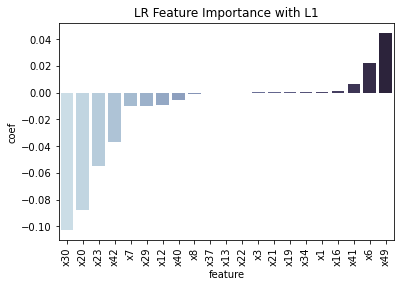

In [35]:
lr_tuned = linear_modeling.find_best_model('auc')
feat_coef = []
feat = zip(linear_modeling.X_train.columns, lr_tuned['model'].coef_[0])
[feat_coef.append([i,j]) for i,j in feat]
feat_coef = pd.DataFrame(feat_coef, columns = ['feature','coef'])
top_feat_lr = feat_coef.loc[abs(feat_coef['coef'])>0].sort_values(by='coef')

feat_plot = sns.barplot(data=top_feat_lr, x='feature', y='coef', palette = "ch:s=.25,rot=-.25")
plt.xticks(rotation=90)
plt.title('LR Feature Importance with L1')
plt.show()

#### Tuning Threshold for Lowest Cost

In [52]:
def extract_best_model_metrics(model):
    return (model.find_best_model('auc')['train_metrics']['y_pred_proba'], 
            model.find_best_model('auc')['test_metrics']['y_pred_proba'], 
            model.y_train,
            model.y_test,
            model.find_best_model('auc')['train_metrics']['matrix'], 
            model.find_best_model('auc')['test_metrics']['matrix'])

In [152]:
train_proba, test_proba, y_train, y_test, conf_train, conf_test = extract_best_model_metrics(logistic_modeling)
logistic_cost_results = tune_cost_proba(train_proba[:,0], test_proba[:,0], y_train, y_test, conf_train, conf_test)
logistic_cost_results[['Threshold', 'Train Cost','Test Cost' ]]

,Threshold,Train Cost,Test Cost
0,0.00,10.030804,10.030729
1,0.05,9.952902,9.942708
2,0.10,9.811161,9.811458
3,0.15,9.767411,9.736979
4,0.20,9.866741,9.868750
5,0.25,10.257143,10.231250
6,0.30,10.836384,10.835417
7,0.35,11.559375,11.723437
8,0.40,12.572098,12.766146
9,0.45,13.752455,14.007812


In [153]:
def plot_cost_tunning(cost_results, threshold):
    sns.lineplot(data=cost_results, x='Threshold', y='Train Cost', color='blue')
    sns.lineplot(data=cost_results, x='Threshold', y='Test Cost', color='red')
    plt.title('Tuning Threshold')
    plt.legend(['Train', 'Test'])
    plt.axvline(threshold, color='black', ls='--')
    plt.show()

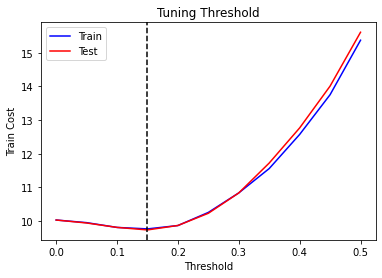

In [154]:
plot_cost_tunning(logistic_cost_results, 0.15)

#### Best Logistic Model Metrics

LogisticRegression with C=0.001, penalty='l1', threshold=0.15 with and a cost of __\\$9.74__ per prediction and an AUC of __0.6718__ for the test set.

## XGB Model

Next, XGBoost (eXtreme Gradient Boosting) was used as a more complex nonlinear tree-based model.  This model significantly improved performance while maintaining some interpretability with feature importances.  However, the XGBoost model overfit the training set such that it achieved a perfect AUC=1.0, and this resulted in a maximum test __AUC=0.9434__.    

### Extreme Gradient Boosting 

In [19]:
xgb_classifier = TuningClassificationModeling(loader.get_df(),'y',
                                           StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=12343),
                                           None, XGBClassifier, None, LabelEncoder(), beta=1,classification_type = 'xgb' )

In [20]:
xgb_classifier.prepare()

In [ ]:
xgb_results = xgb_classifier.parameter_tuning( { 
    'max_depth': [3,6,10],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [100, 500, 1000],
    'colsample_bytree': [0.3, 0.7],
 }, XGBClassifier);

#### Selecting Best XGB Model

In [112]:
best_xgb_model= xgb_classifier.find_best_model('auc')
best_xgb_model['model']

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=8, num_parallel_tree=1,
              predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [113]:
{ metric: best_xgb_model['train_metrics'][metric] for metric in ['auc', 'cost', 'matrix'] }

{'auc': 1.0,
 'cost': 0.0,
 'matrix': array([[67062,     0],
        [    0, 44938]])}

In [114]:
{ metric: best_xgb_model['test_metrics'][metric] for metric in ['auc', 'cost', 'matrix'] }

{'auc': 0.9434452613876319,
 'cost': -3.0145833333333334,
 'matrix': array([[27657,  1084],
        [ 1452, 17807]])}

### Feature Importance

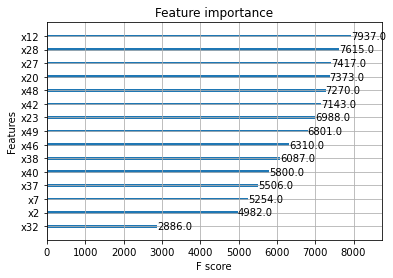

In [134]:
best_xgb_model = xgb_classifier.find_best_model('auc')['model']
xgboost.plot_importance(best_xgb_model, max_num_features=15)
plt.show()

#### Tuning Threshold for Lowest Cost

In [155]:
train_proba, test_proba, y_train, y_test, conf_train, conf_test = extract_best_model_metrics(xgb_classifier)
xgb_cost_results = tune_cost_proba(train_proba[:,0], test_proba[:,0], y_train, y_test, conf_train, conf_test)
xgb_cost_results[['Threshold', 'Train Cost','Test Cost' ]]

,Threshold,Train Cost,Test Cost
0,0.00,10.030804,10.030729
1,0.05,0.033705,2.707813
2,0.10,0.000223,2.445833
3,0.15,-0.000000,2.398438
4,0.20,-0.000000,2.398438
5,0.25,-0.000000,2.470312
6,0.30,-0.000000,2.526562
7,0.35,-0.000000,2.616146
8,0.40,-0.000000,2.752083
9,0.45,-0.000000,2.850521


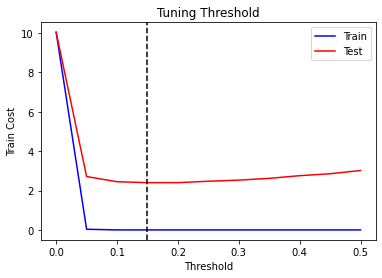

In [156]:
plot_cost_tunning(xgb_cost_results, 0.15)

#### Best XGB Model Metrics

XBG Classifier with max_depth= 10, learning_rate= 0.1, n_estimators= 1000, colsample_bytree= 0.7, threshold=0.15 with and a cost of __\\$2.40__ per prediction and an AUC of __0.9434__ for the test set.

## Neural Network Model

Finally, a Neural Network model was fit on the dataset, and its performance was compared against the rest of the models.  This was the most complex model with the least interpretability.

### Neural Network

In [24]:
nn_modeling = TuningClassificationModeling(loader.get_df(),'y',
                                           StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=12343),
                                           SimpleImputer(missing_values=np.nan, strategy='mean'), NNModel, None, LabelEncoder(), beta=1,classification_type='neural' )

In [25]:
nn_modeling.prepare()

In [91]:
nn_model_tunning = nn_modeling.parameter_tuning( { 
        'input':50,
        'layer1':{'s':300, 'activation': 'relu'}, 
        'layer2':{'s':200, 'activation': 'relu'}, 
        'layer3':{'s':100, 'activation': 'relu'},
        'layer4':{'s':1, 'activation':'sigmoid'},
        'loss':'BinaryCrossentropy',
        'metric': tf.keras.metrics.AUC(),
        'epoch':[10,30,100],
        'bs':[10,100,1000,10000], 
        'optimizer':'adam'
        }, NNModel)        

{'input': 50, 'layer1': {'s': 300, 'activation': 'relu'}, 'layer2': {'s': 200, 'activation': 'relu'}, 'layer3': {'s': 100, 'activation': 'relu'}, 'layer4': {'s': 1, 'activation': 'sigmoid'}, 'loss': 'BinaryCrossentropy', 'metric': <keras.metrics.AUC object at 0x7f9f8fae16a0>, 'optimizer': 'adam'}
Epoch 1/10
11200/11200 [==============================] - 18s 2ms/step - loss: 0.4741 - auc: 0.8851
Epoch 2/10
11200/11200 [==============================] - 20s 2ms/step - loss: 0.2344 - auc: 0.9651
Epoch 3/10
11200/11200 [==============================] - 19s 2ms/step - loss: 0.1943 - auc: 0.9758
Epoch 4/10
11200/11200 [==============================] - 18s 2ms/step - loss: 0.1728 - auc: 0.9805
Epoch 5/10
11200/11200 [==============================] - 18s 2ms/step - loss: 0.1602 - auc: 0.9829
Epoch 6/10
11200/11200 [==============================] - 17s 2ms/step - loss: 0.1493 - auc: 0.9848
Epoch 7/10
11200/11200 [==============================] - 18s 2ms/step - loss: 0.1434 - auc: 0.9858
Ep

12/12 [==============================] - 1s 60ms/step - loss: 0.3196 - auc: 0.9349
Epoch 29/30
12/12 [==============================] - 1s 57ms/step - loss: 0.3040 - auc: 0.9415
Epoch 30/30
12/12 [==============================] - 1s 55ms/step - loss: 0.3063 - auc: 0.9405
Epoch 1/100
11200/11200 [==============================] - 17s 2ms/step - loss: 0.4838 - auc: 0.9164
Epoch 2/100
11200/11200 [==============================] - 18s 2ms/step - loss: 0.2280 - auc: 0.9670
Epoch 3/100
11200/11200 [==============================] - 17s 2ms/step - loss: 0.1914 - auc: 0.9764
Epoch 4/100
11200/11200 [==============================] - 17s 2ms/step - loss: 0.1721 - auc: 0.9806
Epoch 5/100
11200/11200 [==============================] - 17s 2ms/step - loss: 0.1604 - auc: 0.9827
Epoch 6/100
11200/11200 [==============================] - 17s 2ms/step - loss: 0.1492 - auc: 0.9848
Epoch 7/100
11200/11200 [==============================] - 16s 1ms/step - loss: 0.1420 - auc: 0.9861
Epoch 8/100
11200/11

1120/1120 [==============================] - 2s 2ms/step - loss: 0.0310 - auc: 0.9988
Epoch 61/100
1120/1120 [==============================] - 3s 2ms/step - loss: 0.0314 - auc: 0.9988
Epoch 62/100
1120/1120 [==============================] - 3s 2ms/step - loss: 0.0297 - auc: 0.9990
Epoch 63/100
1120/1120 [==============================] - 3s 2ms/step - loss: 0.0310 - auc: 0.9988
Epoch 64/100
1120/1120 [==============================] - 3s 3ms/step - loss: 0.0292 - auc: 0.9989
Epoch 65/100
1120/1120 [==============================] - 3s 3ms/step - loss: 0.0296 - auc: 0.9988
Epoch 66/100
1120/1120 [==============================] - 3s 3ms/step - loss: 0.0274 - auc: 0.9989
Epoch 67/100
1120/1120 [==============================] - 3s 2ms/step - loss: 0.0307 - auc: 0.9988
Epoch 68/100
1120/1120 [==============================] - 3s 3ms/step - loss: 0.0258 - auc: 0.9991
Epoch 69/100
1120/1120 [==============================] - 3s 3ms/step - loss: 0.0307 - auc: 0.9987
Epoch 70/100
1120/1120 

12/12 [==============================] - 1s 56ms/step - loss: 0.3116 - auc: 0.9390
Epoch 28/100
12/12 [==============================] - 1s 56ms/step - loss: 0.3210 - auc: 0.9345
Epoch 29/100
12/12 [==============================] - 1s 57ms/step - loss: 0.3001 - auc: 0.9434
Epoch 30/100
12/12 [==============================] - 1s 58ms/step - loss: 0.2982 - auc: 0.9440
Epoch 31/100
12/12 [==============================] - 1s 59ms/step - loss: 0.3461 - auc: 0.9253
Epoch 32/100
12/12 [==============================] - 1s 61ms/step - loss: 0.3193 - auc: 0.9352
Epoch 33/100
12/12 [==============================] - 1s 55ms/step - loss: 0.2950 - auc: 0.9451
Epoch 34/100
12/12 [==============================] - 1s 63ms/step - loss: 0.2948 - auc: 0.9450
Epoch 35/100
12/12 [==============================] - 1s 56ms/step - loss: 0.2933 - auc: 0.9454
Epoch 36/100
12/12 [==============================] - 1s 56ms/step - loss: 0.2720 - auc: 0.9537
Epoch 37/100
12/12 [==============================] -

#### Selecting Best Neural Network Model

In [98]:
best_nn_model = nn_modeling.find_best_model('auc')
{
    'batch_size': best_nn_model['model'].batch_size, 
    'epoch': best_nn_model['model'].epoch,
    'loss': best_nn_model['model'].loss,
    'metric': best_nn_model['model'].metric,
    'optimizer': best_nn_model['model'].optimizer,   
}

{'batch_size': 100,
 'epoch': 100,
 'loss': 'BinaryCrossentropy',
 'metric': <keras.metrics.AUC at 0x7f9f8fae16a0>,
 'optimizer': 'adam'}

In [96]:
best_nn_model['model'].model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_84 (Dense)             (None, 300)               15300     
_________________________________________________________________
dense_85 (Dense)             (None, 200)               60200     
_________________________________________________________________
dense_86 (Dense)             (None, 100)               20100     
_________________________________________________________________
dense_87 (Dense)             (None, 1)                 101       
Total params: 95,701
Trainable params: 95,701
Non-trainable params: 0
_________________________________________________________________


In [109]:
{ metric: best_nn_model['train_metrics'][metric] for metric in ['auc', 'cost', 'matrix'] }

{'auc': 0.9932595957474247,
 'cost': -0.5254464285714285,
 'matrix': array([[66537,   525],
        [  254, 44684]])}

In [110]:
{ metric: best_nn_model['test_metrics'][metric] for metric in ['auc', 'cost', 'matrix'] }

{'auc': 0.9602827258901632,
 'cost': -2.5692708333333334,
 'matrix': array([[27719,  1022],
        [  845, 18414]])}

#### Tunning Treshold to for Lowest Cost

In [125]:
train_proba, test_proba, y_train, y_test, conf_train, conf_test = extract_best_model_metrics(nn_modeling)
nn_cost_results = tune_cost_proba(1-train_proba, 1-test_proba, y_train, y_test, conf_train, conf_test)
nn_cost_results[['Threshold', 'Train Cost','Test Cost' ]]

,Threshold,Train Cost,Test Cost
0,0.00,10.030804,10.030729
1,0.05,0.366295,1.963542
2,0.10,0.343527,2.026042
3,0.15,0.346429,2.107292
4,0.20,0.369643,2.179688
5,0.25,0.380357,2.230208
6,0.30,0.400893,2.302083
7,0.35,0.429241,2.360417
8,0.40,0.450893,2.428125
9,0.45,0.491295,2.491146


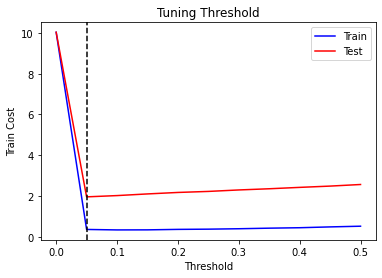

In [157]:
plot_cost_tunning(nn_cost_results, 0.05)

#### Best Neural Network Metrics

Neural Network Model with batch_size= 100, epoch=100, loss=BinaryCrossEntropy, metric=auc, optimizer=adam, with a  threshold=0.05 with and a cost of __\\$1.96__ per prediction and an AUC of __0.9603__ for the test set.

### Results <a id='performance-analysis'>

Below are the results from the three models tried for this dataset and their comparison against predictions using the test dataset.

__Logistic Regression:__ This model was the quickest to train and had a result AUC of __0.6718__ and Cost per Prediction of __\\$9.73__ for the test dataset.
 
__XGBoost:__ This model was the longest to train and provided a significant improvement compared to the logistic regression. This model had a tendency to overfit showing difference in the train and test results. This model had a result AUC of __0.9434__ and Cost per Prediction of __\\$2.40__  for the test dataset.

 
__Neural Network:__ This model took significantly longer than the logistic, but much faster than XGB. It provided a slight improvement over the XGBModel and did not overfit to the training data. This model had a result AUC of __0.9603__ and Cost per Prediction of  __\\$1.96__ for the test dataset.


#### Comparisions

The table below compares the key metrics between the models for the test dataset:

| Model |Cost Per Prediction | AUC | # False Positives | # False Negatives | 
|-------|-----|-----|-------------------|-------------------|
|Logistic Regression | \\$9.73 |  0.6718 | 163 | 18043 |
|XGBoost | \\$2.40 | 0.9434 | 452 | 2797 |
|Neural Network | \\$1.96  | 0.9603 | 587 | 1422 |
 



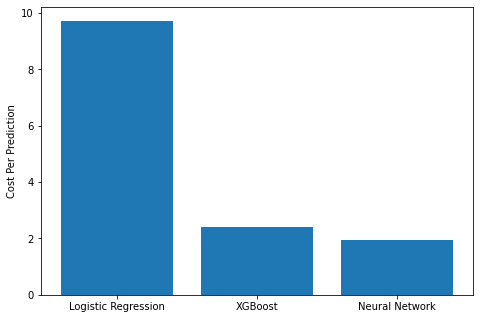

In [132]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
models = ['Logistic Regression', 'XGBoost', 'Neural Network']
costs = [9.73, 2.40, 1.96]
ax.bar(models, costs)
plt.ylabel("Cost Per Prediction")
plt.show()

# Conclusion <a id='conclusion'>

## Final Model <a id='final_model'>


The team recommends using the Neural Network model. This model has an input layer and 3 hidden layers, with 300, 200, and 100 neurons, respectively, that use 'Relu' for the activation function and 1 output layer that uses sigmoid for its activation function. This model provided the best fit (AUC), which was then tuned for lowest overall cost.

### Monetary Outcome

The team recommends using the Neural Network model to minimize the Cost per Prediction. The Neural Network model had cost per prediction of \\$1.96. When compared to the naive model with a cost per prediction of \\$10.03 is an 80.4\% improvement in cost, compared to the Logistic Model that had a cost per prediction of \\$9.73 is a 79.9\% improvement, and compared to the XGBBoost model which had a cost per prediction of \\$2.40 it's an 18\% improvement. Using the recommended model yields an average cost per prediction of less than \\$2.00. 

__If the customer were to make 1000 predictions using the recommended model vs. the naive approach, the customer would save over ~\\$8000.__

### Feature Importance <a id='examining-feature-importance'>

Even though the stakeholder is not interested in the key features for prediction, below are the feature importances according to the Logistic and XGB Models. The logistic feature importance accounts for features that have a linear relationship for predicting the target variable. The XGBoost feature importance differs significantly from the logistic model because the target variable is much better predicted by its non-linear terms. There were 50 total features, of which 7 appear to be the most important for the logistic model (abs coef > 0.02) vs. 14 features for the XGBoost (F-Score > 4000).

#### Logistic Feature Importance

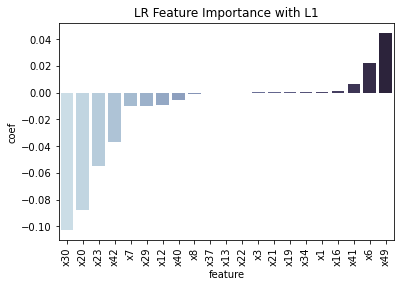

In [33]:
lr_tuned = linear_modeling.find_best_model('auc')

feat_coef = []
feat = zip(linear_modeling.X_train.columns, lr_tuned['model'].coef_[0])
[feat_coef.append([i,j]) for i,j in feat]
feat_coef = pd.DataFrame(feat_coef, columns = ['feature','coef'])
top_feat_lr = feat_coef.loc[abs(feat_coef['coef'])>0].sort_values(by='coef')

feat_plot = sns.barplot(data=top_feat_lr, x='feature', y='coef', palette = "ch:s=.25,rot=-.25")
plt.xticks(rotation=90)
plt.title('LR Feature Importance with L1')
plt.show()

#### XGB Feature Importance

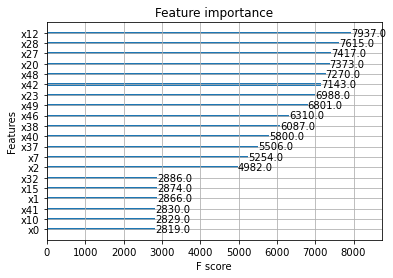

In [140]:
best_xgb_model = xgb_classifier.find_best_model('auc')['model']
xgboost.plot_importance(best_xgb_model, max_num_features=20)
plt.show()

### Future Considerations, Model Enhancements and Alternative Modeling Approaches <a id='model-enhancements'/>

  

To make the model more generalizable, the team recommend in the future using and tuning dropout rates for the neural network model. Also, a small improvement could be made by making an ensemble model. Lastly, the team recommends talking to domain experts to better understand features that could allow for better feature engineering to further reduce potential losses.